In [1]:
from collections import defaultdict
import math
import numpy as np
from numpy import ma
import datetime, time
from datetime import datetime
import netCDF4
from netCDF4 import Dataset, num2date
from scipy.interpolate import griddata
from scipy.spatial import Delaunay


import halem.Base_functions as halem
import halem.Mesh_maker as Mesh_maker
import halem.Functions as Functions
import halem.Calc_path as Calc_path
import halem.Flow_class as Flow_class


import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline

import os
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# User defined values

In [2]:

class flow_wait():
    def __init__(self, name):
        d = datetime.strptime("23/03/2019 00:00:00", "%d/%m/%Y %H:%M:%S") 
        t0 = d.timestamp() 
        x = np.arange(0,1,0.025)
        y = np.arange(0,1,0.025)
        t = np.arange(t0, (t0+30*60*30),10*60)

        y, x = np.meshgrid(y, x)
        y = y.reshape(y.size)
        x = x.reshape(y.size)

        nodes = np.zeros((len(x),2))
        nodes[:,0] = y
        nodes[:,1] = x
        tria = Delaunay(nodes)

        u = []
        v = []
        for node in nodes:
            ut = 0*t + 0
            vt = 0*t + 0
            u.append(ut)
            v.append(vt)

        v = np.transpose(np.array(v))
        u = np.transpose(np.array(u))

        for i in range(len(nodes)):
            node = nodes[i]
            if node[0] > 0.4 and node[0] < 0.6:
                if node[1] > 0.1 and node[1] < 0.9:
                    v[5:50,i] = -10
                    v[75:-1,i] = -10
        
        WD = u*0 + 20
        self.v = v
        self.u = u
        self.t = t
        self.nodes = nodes
        self.tria = Delaunay(nodes)
        self.WD = WD

In [3]:
nl = (3,2.5)
dx_min = 0.01
blend = 1
vship = np.array([[4]])
WD_min = np.array([[5]])
ukc = 1.5
WWL = 40
WVPI = [10000]
name_textfile_flow = 'maaktnietuit'

def compute_cost(week_rate, fuel_rate):
    second_rate = week_rate/7/24/60/60
    return lambda travel_time, speed: (travel_time*second_rate + fuel_rate*travel_time * speed**3)

QQ = compute_cost(700_000, 0.0008)

# Flooding and drying

In [4]:
Load_flow = flow_wait
number_of_neighbor_layers = 1

start_time = time.time()

Roadmap = Mesh_maker.Graph_flow_model(name_textfile_flow, 
                                        dx_min, 
                                        blend, 
                                        nl, 
                                        number_of_neighbor_layers, 
                                        vship, 
                                        Load_flow, 
                                        WD_min,
                                        WVPI,
                                        WWL = WWL,
                                        ukc = ukc,
                                        optimization_type = ['time'],
                                        nodes_index = np.arange(1600)
                                   )

#TomTom.save_object(Roadmap, name_textfile_save)

stop_time = time.time()
computation_time = stop_time - start_time
print("the computational time is:", round(computation_time,2), "sec")

4/4
the computational time is: 14.19 sec


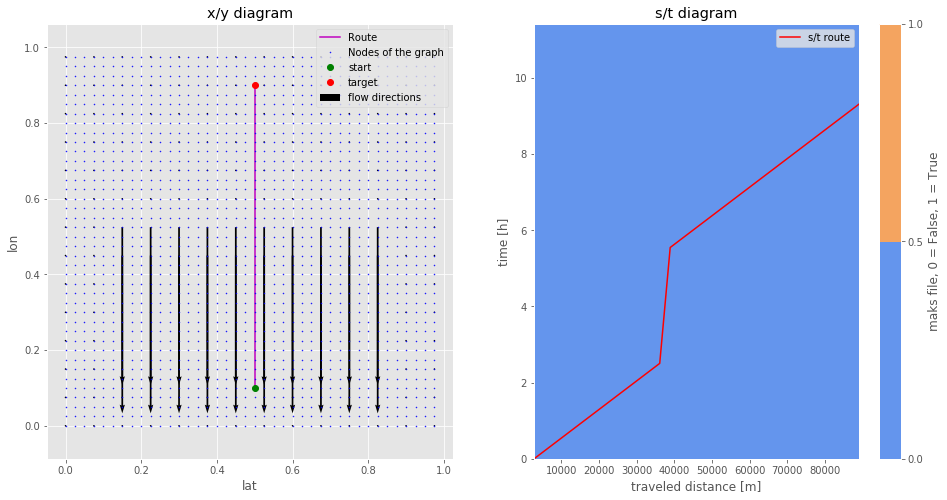

In [5]:
x_r = np.arange(0,1, 0.075)
y_r = np.arange(0,1, 0.075)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = griddata((Roadmap.nodes[:,1], Roadmap.nodes[:,0]), Roadmap.WD[:,10], (x_r, y_r), method= 'linear')
u_r = griddata((Roadmap.nodes[:,1], Roadmap.nodes[:,0]), Roadmap.u[:,10], (x_r, y_r), method= 'linear')
v_r = griddata((Roadmap.nodes[:,1], Roadmap.nodes[:,0]), Roadmap.v[:,10], (x_r, y_r), method= 'linear')



t0 = "23/03/2019 03:00:00"          #Departure time

start = (0.5, 0.1)
stop = (0.5, 0.9)
   
path_w, time_w, dist_w = halem.HALEM_time(start, stop, t0, 4, Roadmap)

fig = plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.axis('equal')
a = 1

#plt.contourf(x_r,y_r,WD_r)

plt.quiver(x_r[::a,::a],
           y_r[::a,::a],
           u_r[::a,::a],
           v_r[::a,::a],
           label = 'flow directions'
          )
plt.plot(path_w[:,0], path_w[:,1], 'm', label = 'Route')
plt.plot(Roadmap.nodes[:,1], Roadmap.nodes[:,0], 'b.', label = 'Nodes of the graph', markersize = 1)
plt.plot(path_w[0, 0], path_w[0, 1], 'go', label = 'start')
plt.plot(path_w[-1, 0 ], path_w[-1, 1], 'ro', label = 'target')


#plt.xlim(start[1] - 0.1, stop[1] + 0.1)
#plt.ylim(start[0] - 0.1, stop[0] + 0.1)
plt.title('x/y diagram')
plt.legend(loc = 'best')
plt.xlabel('lat')
plt.ylabel('lon')

plt.subplot(1,2,2)
halem.plot_timeseries2(path_w, time_w, Roadmap)
plt.title('s/t diagram')

plt.show()